/tmp/ipykernel_249859/2695731761.py:17: DtypeWarning: Columns (2,3,4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/01_raw/weather_data.csv")


Test MSE: 1.478


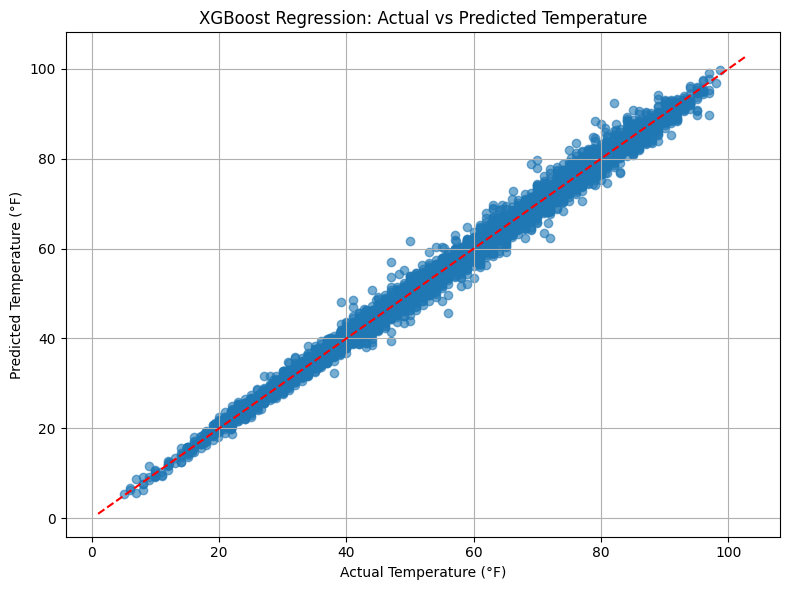

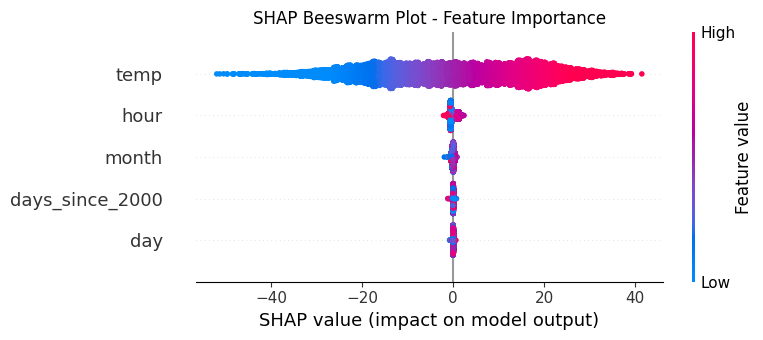

In [41]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import os

os.chdir('/home/zaccosenza/code/project-weather')

# Reference date for days_since feature
REFERENCE_DATE = pd.Timestamp('2000-01-01')

# Load and preprocess
df = pd.read_csv("data/01_raw/weather_data.csv")
df = df[pd.to_datetime(df['valid']) >= pd.to_datetime('2010-01-01')]
df['valid'] = pd.to_datetime(df['valid'], errors='coerce')
df['tmpf'] = pd.to_numeric(df['tmpf'], errors='coerce')
df = df.dropna(subset=['valid', 'tmpf']).sort_values('valid')

# Extract time features
df['month'] = df['valid'].dt.month
df['day'] = df['valid'].dt.day
df['hour'] = df['valid'].dt.hour
df['temp'] = df['tmpf']

# Add days since 2000-01-01 as a float (includes fractional days from hours)
df['days_since_2000'] = (df['valid'] - REFERENCE_DATE).dt.total_seconds() / (24 * 3600)

# Features: time features + days_since_2000 + current temp
feature_cols = ['month', 'day', 'hour', 'days_since_2000', 'temp']
X = df[feature_cols].iloc[:-1]
y = df['tmpf'].shift(-1).iloc[:-1]

# Drop any remaining NaN from target shift
valid_idx = ~y.isna()
X = X[valid_idx]
y = y[valid_idx]

# Train/test split (random, 10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train XGBoost regressor
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.3f}")

# Plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Temperature (°F)")
plt.ylabel("Predicted Temperature (°F)")
plt.title("XGBoost Regression: Actual vs Predicted Temperature")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate and save errors by time
results_df = X_test.copy()
results_df['true_tmpf'] = y_test.values
results_df['pred_tmpf'] = y_pred
results_df['abs_error'] = np.abs(y_test - y_pred)

error_by_time = results_df.groupby(['month', 'day', 'hour'])['abs_error'].mean().reset_index()

# SHAP beeswarm plot
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

plt.figure(figsize=(12, 10))
shap.plots.beeswarm(shap_values, show=False)
plt.title("SHAP Beeswarm Plot - Feature Importance")
plt.tight_layout()
plt.show()

Current Temperature: 33°F
Date features: month=1, day=19, hour=10
Days since 2000-01-01: 9515.42

Found 10 historical profiles with similar starting conditions


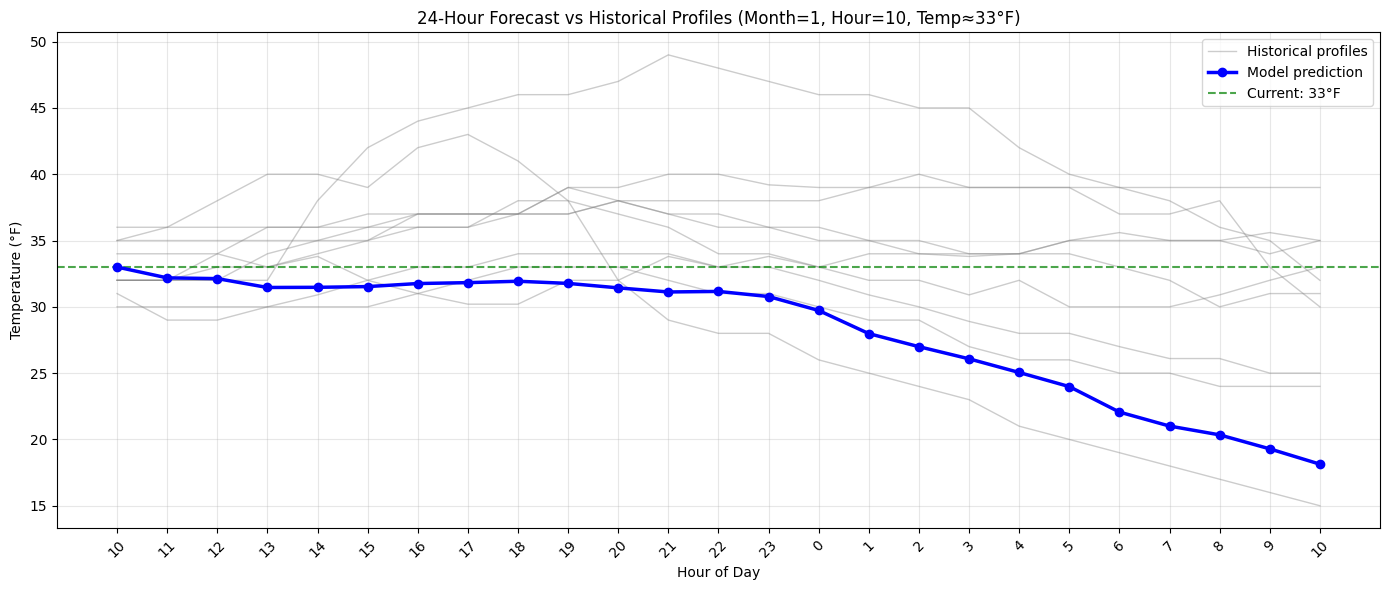


Historical profile dates:
  1. 2017-01-06 10:51 - Start temp: 30.0°F
  2. 2025-01-14 10:51 - Start temp: 31.0°F
  3. 2022-01-18 10:51 - Start temp: 32.0°F
  4. 2014-01-27 10:51 - Start temp: 35.0°F
  5. 2019-01-20 10:02 - Start temp: 36.0°F
  6. 2011-01-27 10:51 - Start temp: 34.0°F
  7. 2024-01-31 10:16 - Start temp: 35.0°F
  8. 2013-01-28 10:51 - Start temp: 32.0°F
  9. 2019-01-27 10:51 - Start temp: 32.0°F
  10. 2024-01-06 10:51 - Start temp: 32.0°F


In [42]:
import requests
from datetime import datetime, timedelta

NYS_NYC_COORDS = (40.7128, -74.0060)

def autoregressive_predict(model, month, day, hour, days_since_2000, temp, n_hours):
    """
    Use the trained 1-step model autoregressively to predict N hours ahead.
    Each prediction becomes input for the next step.
    Returns: list of prediction dicts
    """
    predictions = []
    current_temp = temp
    current_month, current_day, current_hour = month, day, hour
    current_days_since_2000 = days_since_2000
    
    for step in range(n_hours):
        # Predict next hour
        X = pd.DataFrame([[current_month, current_day, current_hour, current_days_since_2000, current_temp]], 
                         columns=feature_cols)
        next_temp = float(model.predict(X)[0])
        
        # Advance time by 1 hour
        current_days_since_2000 += 1/24  # Add 1 hour in days
        current_hour = (current_hour + 1) % 24
        if current_hour == 0:
            current_day = current_day + 1
            if current_day > 28:
                current_day = 1
                current_month = (current_month % 12) + 1
        
        predictions.append({
            'hour_ahead': step + 1,
            'month': current_month,
            'day': current_day,
            'hour': current_hour,
            'days_since_2000': current_days_since_2000,
            'predicted_temp': next_temp
        })
        
        # Use prediction as input for next step
        current_temp = next_temp
    
    return predictions


def get_historical_profiles(df, month, day, hour, temp, n_profiles=5, temp_tolerance=5):
    """
    Find historical 24-hour temperature profiles with similar starting conditions.
    Matches on same month, same hour, and similar starting temperature.
    """
    mask = (
        (df['month'] == month) & 
        (df['hour'] == hour) & 
        (np.abs(df['temp'] - temp) <= temp_tolerance)
    )
    candidates = df[mask].copy()
    
    if len(candidates) == 0:
        return []
    
    profiles = []
    candidate_indices = candidates.index.tolist()
    
    np.random.seed(42)
    if len(candidate_indices) > n_profiles:
        selected_indices = np.random.choice(candidate_indices, size=n_profiles, replace=False)
    else:
        selected_indices = candidate_indices
    
    for idx in selected_indices:
        pos = df.index.get_loc(idx)
        if pos + 25 > len(df):
            continue
        
        profile_data = df.iloc[pos:pos+25]['tmpf'].values
        profile_time = df.iloc[pos]['valid']
        
        if len(profile_data) == 25:
            profiles.append({
                'temps': profile_data,
                'start_time': profile_time,
                'start_temp': profile_data[0]
            })
    
    return profiles


def get_nyc_weather():
    """Get current NYC weather with temperature and date features."""
    lat, lon = NYS_NYC_COORDS
    points_url = f"https://api.weather.gov/points/{lat},{lon}"
    points_data = requests.get(points_url).json()

    forecast_url = points_data["properties"]["forecast"]
    forecast_data = requests.get(forecast_url).json()

    first_period = forecast_data["properties"]["periods"][0]
    start_time = datetime.fromisoformat(first_period["startTime"].replace("Z", "+00:00"))
    
    # Calculate days since 2000-01-01
    days_since_2000 = (start_time - datetime(2000, 1, 1, tzinfo=start_time.tzinfo)).total_seconds() / (24 * 3600)
    
    return {
        "temp": first_period["temperature"],
        "temperature_unit": first_period["temperatureUnit"],
        "month": start_time.month,
        "day": start_time.day,
        "hour": start_time.hour,
        "days_since_2000": days_since_2000,
        "timestamp": start_time
    }


# Get current weather
weather = get_nyc_weather()
print(f"Current Temperature: {weather['temp']}°{weather['temperature_unit']}")
print(f"Date features: month={weather['month']}, day={weather['day']}, hour={weather['hour']}")
print(f"Days since 2000-01-01: {weather['days_since_2000']:.2f}")

# Generate 24-hour autoregressive forecast
predictions = autoregressive_predict(
    model, 
    weather['month'], 
    weather['day'], 
    weather['hour'],
    weather['days_since_2000'],
    weather['temp'], 
    n_hours=24
)
pred_df = pd.DataFrame(predictions)

# Get historical profiles with similar starting conditions
historical_profiles = get_historical_profiles(
    df, 
    weather['month'], 
    weather['day'], 
    weather['hour'], 
    weather['temp'],
    n_profiles=10,
    temp_tolerance=3
)
print(f"\nFound {len(historical_profiles)} historical profiles with similar starting conditions")

# Plot 24-hour forecast with historical profiles
plt.figure(figsize=(14, 6))

# Plot historical profiles in gray
for i, profile in enumerate(historical_profiles):
    label = 'Historical profiles' if i == 0 else None
    plt.plot(range(25), profile['temps'], color='gray', alpha=0.4, linewidth=1, label=label)

# Plot model prediction in blue
temps = pred_df['predicted_temp'].values
plt.plot(range(25), [weather['temp']] + list(temps), 'b-o', markersize=6, linewidth=2.5, label='Model prediction', zorder=10)

# Plot current temperature line
plt.axhline(y=weather['temp'], color='green', linestyle='--', alpha=0.7, label=f"Current: {weather['temp']}°F")

# Add hour labels on x-axis
hour_labels = [weather['hour']] + [(weather['hour'] + i + 1) % 24 for i in range(24)]
plt.xticks(range(25), hour_labels, rotation=45)

plt.xlabel("Hour of Day")
plt.ylabel("Temperature (°F)")
plt.title(f"24-Hour Forecast vs Historical Profiles (Month={weather['month']}, Hour={weather['hour']}, Temp≈{weather['temp']}°F)")
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print historical profile dates
print("\nHistorical profile dates:")
for i, profile in enumerate(historical_profiles):
    print(f"  {i+1}. {profile['start_time'].strftime('%Y-%m-%d %H:%M')} - Start temp: {profile['start_temp']:.1f}°F")